In [1]:
import scipy as scipy
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import load_model

import helper
from helper import exec_time_and_y_pred, get_flops

2025-02-16 14:22:01.082559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-16 14:22:01.109983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-16 14:22:01.116636: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 14:22:01.138613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-16 14:22:02.552736: W tensorflow/comp

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


2025-02-16 14:22:04.717790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31139 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:23:00.0, compute capability: 7.0


In [3]:
Test = False

In [4]:
if Test:
    folder = "../dataset_train_val_test/"
else:
    folder = "../dataset_train_val/"
filename = "dataset_train_val_challenge_5.npz"
fullpath = folder+filename

In [5]:
print('Reading file: ',fullpath) 
data = np.load(fullpath)

Reading file:  ../dataset_train_val/dataset_train_val_challenge_5.npz


In [6]:
if Test:
    dataInput = data["trainData_test"]
    dataLabels = data["trainLabels_test"]
    dataPractical = data["trainPractical_test"]
    dataLinearInterpolation = data["trainLinearInterpolation_test"]
    otherLabels= data["otherLabels_test"]
else:
    dataInput = data["trainData_validation"]
    dataLabels = data["trainLabels_validation"]
    dataPractical = data["trainPractical_validation"]
    dataLinearInterpolation = data["trainLinearInterpolation_validation"]
    otherLabels = data["otherLabels_validation"]

In [7]:
# Print shapes to verify
#5% (84, 612, 14, 2)
#10% (169, 612, 14, 2)
#15% (253, 612, 14, 2)
#20% (338, 612, 14, 2)
#25% (422, 612, 14, 2)
#50% (845, 612, 14, 2)
#75% (1267, 612, 14, 2)
#100% (1690, 612, 14, 2)
print("Input Data shape:", dataInput.shape)

Input Data shape: (84, 612, 14, 2)


In [8]:
#model name
#If you are using TF 2.17, make sure you install keras-nightly via pip (pip install keras-nightly), otherwise you will have errors loading the model. 
model_filename = "..//trained_models/SRCNN_217.keras"

In [9]:
model = load_model(model_filename)

In [10]:
#Calculate execution time
total_time_se, time_per_sample_se, y_pred = exec_time_and_y_pred(model, dataInput)

I0000 00:00:1739715726.983132   71883 service.cc:146] XLA service 0x7fadf80264d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739715726.983180   71883 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM3-32GB, Compute Capability 7.0
2025-02-16 14:22:06.990824: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-16 14:22:07.057007: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step

I0000 00:00:1739715727.646236   71883 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


In [11]:
print(f"Total execution time: {total_time_se:.6f} seconds")
print(f"Execution time per sample: {time_per_sample_se:.6f} seconds")

Total execution time: 1.319134 seconds
Execution time per sample: 0.015704 seconds


In [12]:
print("DNN")
first_dimension = dataInput.shape[0]
dnn_mse = mean_squared_error(dataLabels.reshape(first_dimension,-1), y_pred.reshape(first_dimension,-1))
dnn_mae = mean_absolute_error(dataLabels.reshape(first_dimension,-1), y_pred.reshape(first_dimension,-1))
dnn_r2 = r2_score(dataLabels.reshape(first_dimension,-1), y_pred.reshape(first_dimension,-1))
print("MSE: %.4f" % dnn_mse)
print("MAE: %.4f" % dnn_mae)
print('R²: %.4f' % dnn_r2)

DNN
MSE: 0.0189
MAE: 0.0991
R²: 0.9529


In [13]:
print("Practical CE")
practical_mse =  mean_squared_error(dataLabels.reshape(first_dimension,-1), dataPractical.reshape(first_dimension,-1))
practical_mae = mean_absolute_error(dataLabels.reshape(first_dimension,-1), dataPractical.reshape(first_dimension,-1))
practical_r2 =  r2_score(dataLabels.reshape(first_dimension,-1), dataPractical.reshape(first_dimension,-1))

print("MSE: %.4f" % practical_mse)
print("MAE: %.4f" % practical_mae)
print('R²: %.4f' % practical_r2)

Practical CE
MSE: 0.0279
MAE: 0.1148
R²: 0.9305


In [14]:
print("Linear CE")
mse_linear = mean_squared_error(dataLabels.reshape(first_dimension,-1), dataLinearInterpolation.reshape(first_dimension,-1))
mae_linear = mean_absolute_error(dataLabels.reshape(first_dimension,-1), dataLinearInterpolation.reshape(first_dimension,-1))
r2_linear = r2_score(dataLabels.reshape(first_dimension,-1), dataLinearInterpolation.reshape(first_dimension,-1))
print("MSE: %.4f" % mse_linear)
print("MAE: %.4f" % mae_linear)
print('R²: %.4f' % r2_linear)

Linear CE
MSE: 0.1993
MAE: 0.2610
R²: 0.5073


In [15]:
print("Comparing and improvement")
print(f'DNN MSE: {dnn_mse}, Practical: {practical_mse}, Linear: {mse_linear}')
print(f'DNN vs. Linear MSE {(mse_linear-dnn_mse)*100/mse_linear}, CNN vs. Practical {(practical_mse-dnn_mse)*100/practical_mse}')

Comparing and improvement
DNN MSE: 0.018940023811707736, Practical: 0.027929328106597748, Linear: 0.19930684842513324
DNN vs. Linear MSE 90.49705318138012, CNN vs. Practical 32.185895273171525


In [16]:
# Generate a random index
#random_index = np.random.randint(0, trainData_validation.shape[0])
random_index = 8
input_sample = dataInput[random_index]
label_sample = dataLabels[random_index]
practical_sample = dataPractical[random_index]
linearInterpol_sample = dataLinearInterpolation[random_index]
predicted_sample = model.predict(np.expand_dims(input_sample, axis=0))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


In [17]:
# Compute the magnitude using the absolute value of the last dimension
input_magnitude = np.linalg.norm(input_sample, axis=-1)
label_magnitude = np.linalg.norm(label_sample, axis=-1)
practical_magnitude = np.linalg.norm(practical_sample, axis=-1)
linearInterpol_magnitude = np.linalg.norm(linearInterpol_sample, axis=-1)
predicted_magnitude = np.linalg.norm(predicted_sample, axis=-1)

In [18]:
cmax = np.max(np.concatenate((np.abs(label_magnitude), np.abs(practical_magnitude), np.abs(predicted_magnitude)), axis=0))
cmin = np.min(np.concatenate((np.abs(label_magnitude), np.abs(practical_magnitude), np.abs(linearInterpol_magnitude), np.abs(predicted_magnitude)), axis=0))

In [19]:
# Calculate the Mean Squared Error
mse_linear = np.mean((label_sample - linearInterpol_sample) ** 2)
print(f'MSE Linear: {mse_linear}')

mse_prac = np.mean((label_sample - practical_sample) ** 2)
print(f'MSE CE practical: {mse_prac}')

# Calculate the Mean Squared Error
mse_nn = np.mean((label_sample - predicted_sample) ** 2)
print(f'MSE DNN: {mse_nn}')

MSE Linear: 0.04128833058871371
MSE CE practical: 0.018847764624689844
MSE DNN: 0.010347089516111576


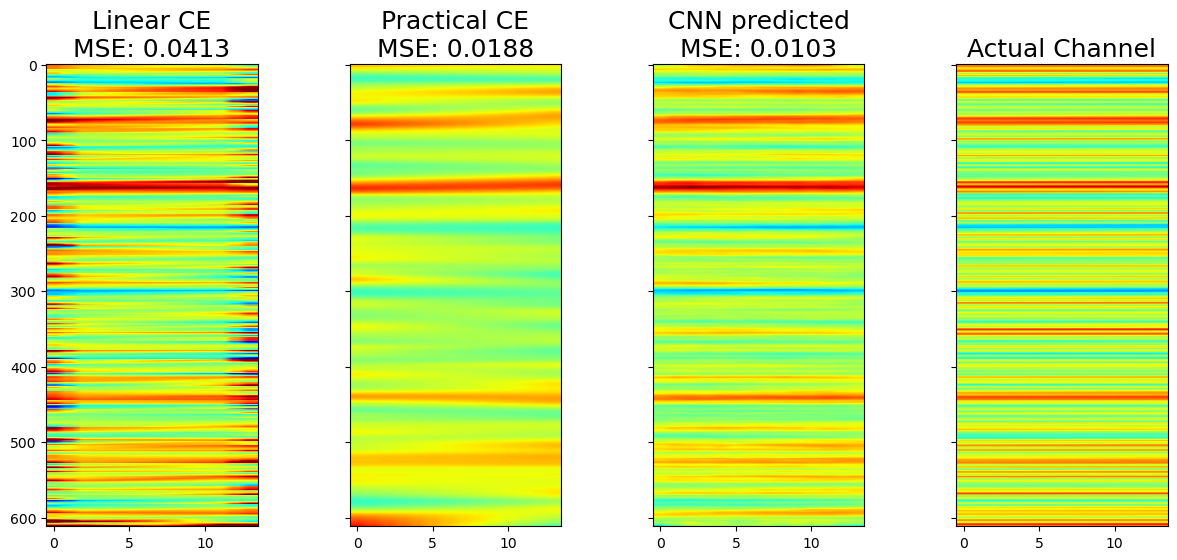

In [20]:
# Plotting
#cmap = parula_colormap
cmap = "jet"
font_size = 18
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,6), sharey=True)

axs[0].imshow(np.abs(linearInterpol_magnitude), cmap=cmap, vmin=cmin, vmax=cmax)
axs[0].set_aspect(0.05)
axs[0].set_title(f'Linear CE\nMSE: {mse_linear:.4f}',fontsize=font_size)

axs[1].imshow(np.abs(practical_magnitude), cmap=cmap, vmin=cmin, vmax=cmax)
axs[1].set_aspect(0.05)
axs[1].set_title(f'Practical CE\nMSE: {mse_prac:.4f}',fontsize=font_size)

axs[2].imshow(np.abs(predicted_magnitude), cmap=cmap, vmin=cmin, vmax=cmax)
axs[2].set_aspect(0.05)
axs[2].set_title(f'CNN predicted\nMSE: {mse_nn:.4f}',fontsize=font_size)

axs[3].imshow(np.abs(label_magnitude), cmap=cmap, vmin=cmin, vmax=cmax)
axs[3].set_aspect(0.05)
axs[3].set_title('Actual Channel',fontsize=font_size)

plt.show()

In [21]:
unique_elements, counts = np.unique(otherLabels[:,1], return_counts=True)

In [22]:
# Unique SNR values
unique_snr_values, unique_snr_counts = np.unique(otherLabels[:, 1], return_counts=True)

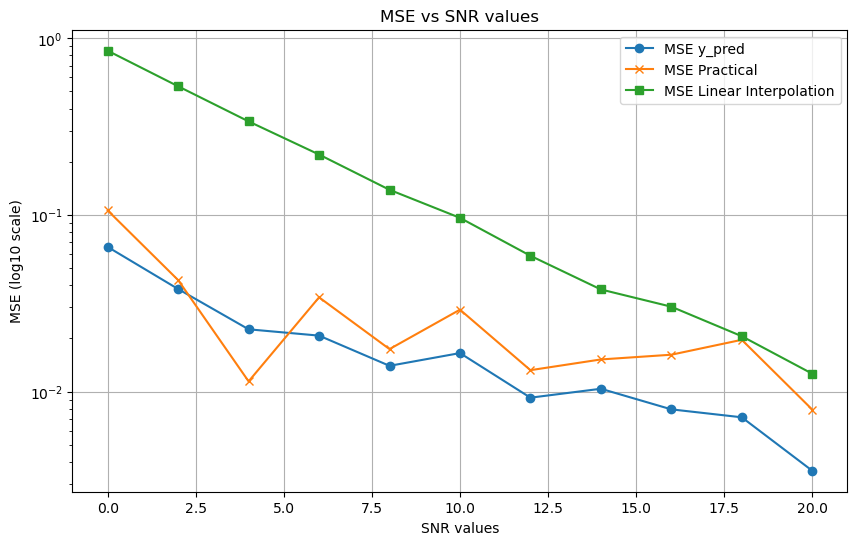

In [23]:
# Calculate MSE for each SNR value
mse_results = {
    "SNR": [],
    "MSE_y_pred": [],
    "MSE_practical": [],
    "MSE_linear_interpolation": []
}

for snr, idx in zip(unique_snr_values, unique_snr_counts):
    indices = otherLabels[:, 1] == snr

    # Determine the first dimension for reshaping
    first_dimension = idx

    mse_y_pred = mean_squared_error(
        dataLabels[indices].reshape(first_dimension, -1),
        y_pred[indices].reshape(first_dimension, -1)
    )
    mse_practical = mean_squared_error(
        dataLabels[indices].reshape(first_dimension, -1),
        dataPractical[indices].reshape(first_dimension, -1)
    )
    mse_linear_interpolation = mean_squared_error(
        dataLabels[indices].reshape(first_dimension, -1),
        dataLinearInterpolation[indices].reshape(first_dimension, -1)
    )

    mse_results["SNR"].append(snr)
    mse_results["MSE_y_pred"].append(mse_y_pred)
    mse_results["MSE_practical"].append(mse_practical)
    mse_results["MSE_linear_interpolation"].append(mse_linear_interpolation)

# Plotting the results with log10 scale for y-axis
plt.figure(figsize=(10, 6))
plt.plot(mse_results["SNR"], mse_results["MSE_y_pred"], label="MSE y_pred", marker='o')
plt.plot(mse_results["SNR"], mse_results["MSE_practical"], label="MSE Practical", marker='x')
plt.plot(mse_results["SNR"], mse_results["MSE_linear_interpolation"], label="MSE Linear Interpolation", marker='s')
plt.xlabel("SNR values")
plt.ylabel("MSE (log10 scale)")
plt.yscale('log')
plt.title("MSE vs SNR values")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Calculate FLOPS
# Forward pass to build the model
model(predicted_sample.reshape(1, 612, 14, 2).astype(np.float32))
flops_dnn = get_flops(model)

W0000 00:00:1739715730.151808   71561 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739715730.172866   71561 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739715730.173222   71561 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739715730.173715   71561 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739715730.174691   71561 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739715730.175037   71561 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739715730.175429   71561 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739715730.289400   71561 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739715730.289854   71561 gp

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation ker

2025-02-16 14:22:10.350079: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-02-16 14:22:10.356385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31139 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:23:00.0, compute capability: 7.0


e math behind it.

Profile:
node name | # float_ops
Conv2D                   240.18m float_ops (100.00%, 99.65%)
BiasAdd                  839.66k float_ops (0.35%, 0.35%)

======================End of Report==========================


In [25]:
#final results
print(f'Total GFLOPS: {flops_dnn/1000000000}')
print(f'MSE: {dnn_mse}')

Total GFLOPS: 0.24101784
MSE: 0.018940023811707736
